## Alzheimer

In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn import svm
from sklearn.metrics import auc, roc_auc_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import pickle



## Data reading and preliminary analysis

In [2]:
### Origin: https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset
alz = pd.read_csv('./data/raw/alzheimers_disease_data.csv',index_col='PatientID')
alz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2149 entries, 4751 to 6899
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   int64  
 1   Gender                     2149 non-null   int64  
 2   Ethnicity                  2149 non-null   int64  
 3   EducationLevel             2149 non-null   int64  
 4   BMI                        2149 non-null   float64
 5   Smoking                    2149 non-null   int64  
 6   AlcoholConsumption         2149 non-null   float64
 7   PhysicalActivity           2149 non-null   float64
 8   DietQuality                2149 non-null   float64
 9   SleepQuality               2149 non-null   float64
 10  FamilyHistoryAlzheimers    2149 non-null   int64  
 11  CardiovascularDisease      2149 non-null   int64  
 12  Diabetes                   2149 non-null   int64  
 13  Depression                 2149 non-null   int64  

In [4]:
alz.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
PatientID,,,,,,,,,,,,,,,,,,,,,
4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


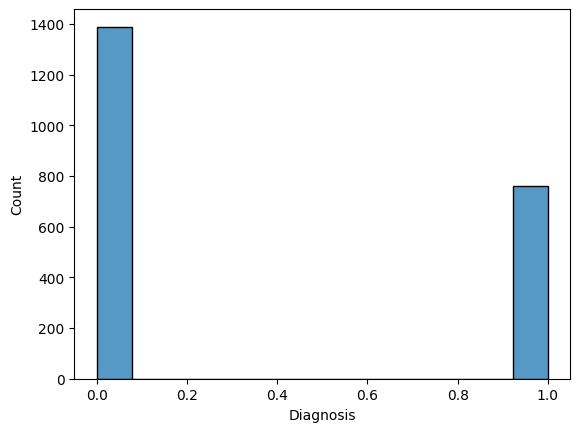

In [112]:
sns.histplot(alz['Diagnosis']);

<Axes: >

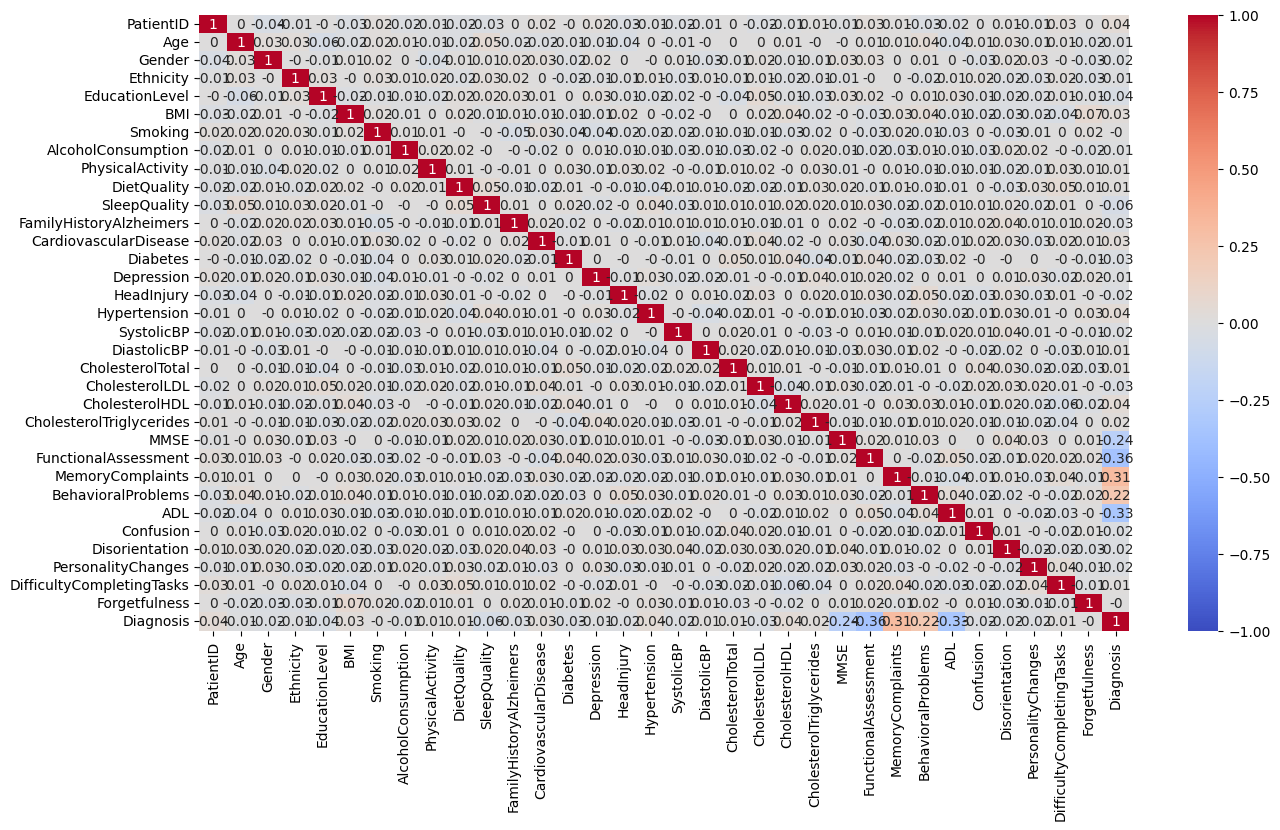

In [ ]:
alz_num = alz.select_dtypes(include=['int','float'])
plt.figure(figsize=(15,8))
sns.heatmap(round(alz_num.corr(),2), vmin=-1,annot=True,cmap='coolwarm')


In [3]:
### Datasets divided by category
alz_dem = alz[['Age','Gender','Ethnicity','EducationLevel','Diagnosis']]
alz_lif = alz[['BMI','Smoking','AlcoholConsumption','PhysicalActivity','DietQuality','SleepQuality','Diagnosis']]
alz_med = alz[['FamilyHistoryAlzheimers','CardiovascularDisease','Diabetes','Depression','HeadInjury','Hypertension','Diagnosis']]
alz_cli = alz[['SystolicBP','DiastolicBP','CholesterolTotal','CholesterolLDL','CholesterolHDL','CholesterolTriglycerides','Diagnosis']]
alz_cog = alz[['MMSE','FunctionalAssessment','MemoryComplaints','BehavioralProblems','ADL','Diagnosis']]
alz_sym = alz[['Confusion','Disorientation','PersonalityChanges','DifficultyCompletingTasks','Forgetfulness','Diagnosis']]

<Axes: >

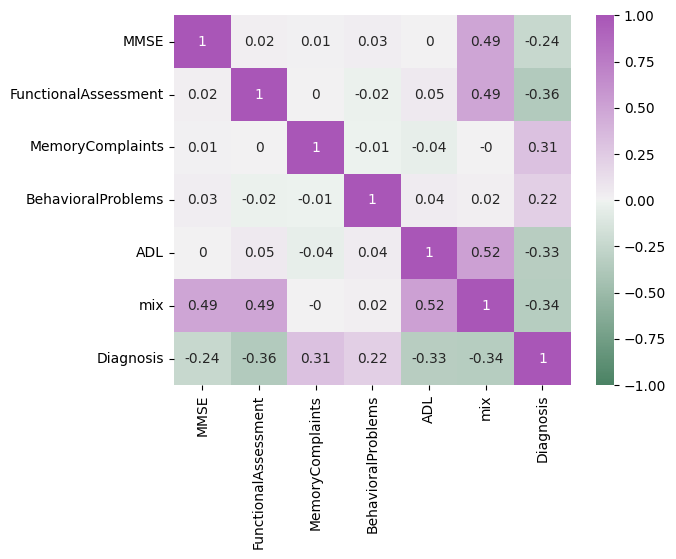

In [69]:
palette = sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(round(alz_dum.corr(),2), vmin=-1,annot=True, cmap=palette)


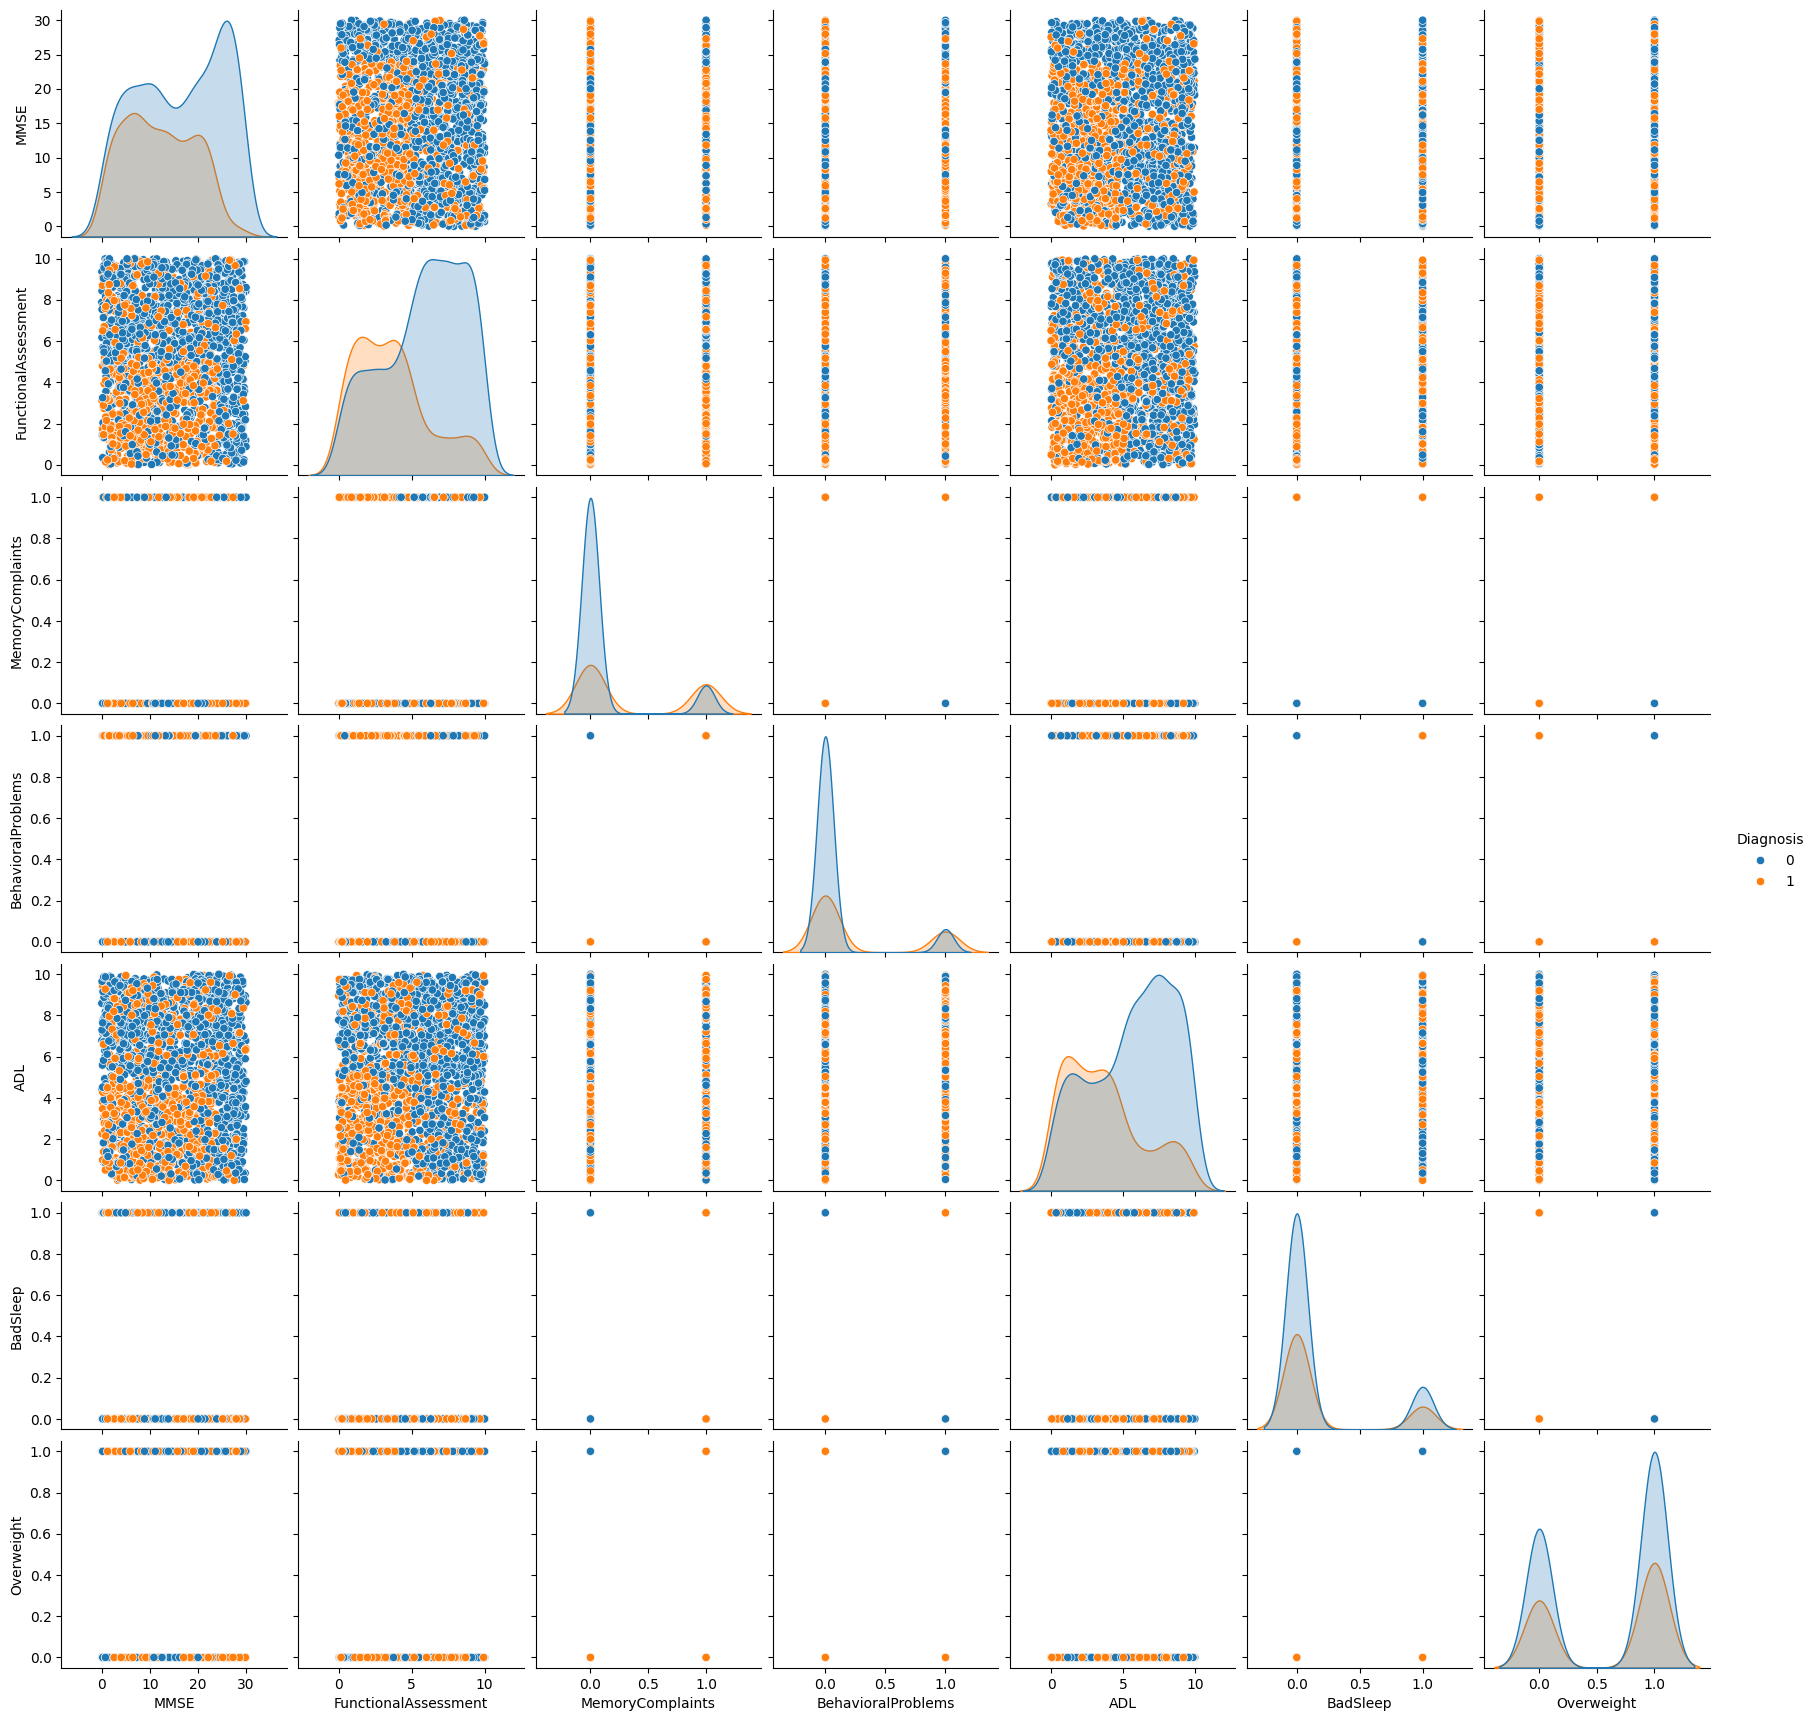

In [29]:
sns.pairplot(data=alz_dum,hue='Diagnosis')

In [14]:
alz.describe().loc[['count','mean','50%','max','std']].T

,count,mean,50%,max,std
Age,2149.0,74.908795,75.000000,90.000000,8.990221
Gender,2149.0,0.506282,1.000000,1.000000,0.500077
Ethnicity,2149.0,0.697534,0.000000,3.000000,0.996128
EducationLevel,2149.0,1.286645,1.000000,3.000000,0.904527
BMI,2149.0,27.655697,27.823924,39.992767,7.217438
Smoking,2149.0,0.288506,0.000000,1.000000,0.453173
AlcoholConsumption,2149.0,10.039442,9.934412,19.989293,5.757910
PhysicalActivity,2149.0,4.920202,4.766424,9.987429,2.857191
DietQuality,2149.0,4.993138,5.076087,9.998346,2.909055
SleepQuality,2149.0,7.051081,7.115646,9.999840,1.763573


## Feature Engineering

In [4]:
### New dummies:
alz['BadSleep'] = np.where(alz['SleepQuality']<5,1,0)
alz['Overweight'] = np.where(alz['BMI']>25,1,0)
alz['mix'] = alz['FunctionalAssessment'] * alz['MMSE'] * alz['ADL']
alz['mix2'] = alz['MemoryComplaints'] + alz['BehavioralProblems']
alz_dum = alz[['MMSE','FunctionalAssessment','MemoryComplaints','BehavioralProblems','ADL','mix','Diagnosis']]
alz_dum2 = alz[['MMSE','FunctionalAssessment','MemoryComplaints','BehavioralProblems','ADL','mix','mix2','Diagnosis']]

In [37]:
alz['mix2'].mean()

np.float64(0.36482084690553745)

## Baseline model

In [5]:
### Model 1
np.random.seed(42)
x1 = alz_dum.drop(columns='Diagnosis')
y1 = alz_dum['Diagnosis']
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y1, test_size=.3,stratify=y1)
# scaler = StandardScaler()
# scaler.fit_transform(x1_train)
# x1_test = scaler.transform(x1_test)
svc = svm.SVC()
svc.fit(x1_train,y1_train)
y1_pred = svc.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,y1_pred))
print('AUC:',roc_auc_score(y1_test,y1_pred))
print(confusion_matrix(y1_test,y1_pred))

Accuracy: 0.7069767441860465
AUC: 0.6809447179098825
[[321  96]
 [ 93 135]]


In [6]:
### Model 2
np.random.seed(42)
x2 = alz_dum.drop(columns=['Diagnosis'])
y2 = alz_dum['Diagnosis']
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,y2, test_size=.3,stratify=y1)
# scaler2 = StandardScaler()
# scaler2.fit_transform(x2_train)
# x2_test = scaler2.transform(x2_test)
xgb= XGBClassifier()
xgb.fit(x2_train,y2_train)
y2_pred = xgb.predict(x2_test)
xgbfilcv = cross_val_score(xgb,x2,y2, cv=10, scoring='accuracy')
print("Accuracy promedio", round(xgbfilcv.mean(),3))
print('Accuracy:',accuracy_score(y2_test,y2_pred))
print('AUC:',roc_auc_score(y2_test,y2_pred))
print(confusion_matrix(y2_test,y2_pred))


Accuracy promedio 0.943
Accuracy: 0.9441860465116279
AUC: 0.9379496402877697
[[400  17]
 [ 19 209]]


## Exportación a pickle de modelo

In [8]:
with open("models/xgb_baseline.pkl", "wb") as f:
    pickle.dump(xgb,f)

## Modelo desde utils y pickle

In [3]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn import svm
from sklearn.metrics import auc, roc_auc_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import pickle
# sys.path.append(os.path.abspath(r'C:\Users\raulg\Documents\THEBRIDGE_DS\0.-Repo_Git\ml_alzheimer_class\src'))
sys.path.append(os.path.relpath('../src'))
import utils as ut  ### TODO: Intentar que sea relative path

In [5]:
with open('../models/class/xgb_baseline.pkl', 'rb') as f:
    xgb_baseline = pickle.load(f)

In [7]:
alz = pd.read_csv('../data/class/raw/alzheimers_disease_data.csv',index_col='PatientID')
alz = ut.feat_eng(alz)
alz_dum = alz[['MMSE','FunctionalAssessment','MemoryComplaints','BehavioralProblems','ADL','mix','mix2','Diagnosis']]
x1_train, x1_test, y1_train, y1_test = ut.train_test(alz_dum)

In [26]:
xgb_baseline.fit(x1_train,y1_train)
y1_pred = xgb_baseline.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,y1_pred))
print('AUC:',roc_auc_score(y1_test,y1_pred))
print(confusion_matrix(y1_test,y1_pred))

Accuracy: 0.951937984496124
AUC: 0.9449387858134545
[[404  13]
 [ 18 210]]


In [31]:
x1_test.shape

(645, 7)

In [32]:
type(x1_test)

pandas.core.frame.DataFrame

In [5]:
xgb_baseline.predict(np.array([[1,1,1,1,1,1]]))

array([1])

In [4]:
mmse = "10"
func_asses = 30
memory = "No"
behav = "Yes"
adl = 10
result = ut.model_prediction(mmse,func_asses,memory,behav,adl)
print(result)

Patient shows no signs of alzehimer


## Pruebas con streamlit

In [38]:
mmse ="2"
int(mmse)

2